In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans as kmeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr as pears
import seaborn as sns
import math
import os
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical

excelpath = 'excel_gaming_data'
ddict = {} # Created A dataframe dictionary to modify each dictionary iteratively
for filename in os.listdir(excelpath): # Iterates through each excel file
    f = os.path.join(excelpath, filename)
    # checking if it is a file
    if os.path.isfile(f) & ~filename.startswith('.'):
        ddict[filename[-6:-4]] = pd.read_excel(excelpath + '/' + filename) # sets the value of each dictionary
        
        for idx, val in enumerate(ddict[filename[-6:-4]].iloc[0,:]): # Iterates through each column of the excel spread sheet in question
            if idx > 1:
                if idx > 7:
                    ddict[filename[-6:-4]].columns.values[idx] = ddict[filename[-6:-4]].iloc[0,idx] + ' 20' + str(filename[-6:-4]) # Changes the column name using the next year and the month. The next year is used if past December, which corresponds to an index of 7, ad
                else:
                    ddict[filename[-6:-4]].columns.values[idx] = ddict[filename[-6:-4]].iloc[0,idx] + ' 20' + str(filename[-9:-7]) # Changes the column name using the first year specified and the month
        if filename[-6:-4] != '11': # Removes the first 2 columns of the excel spread sheet, except if it is the starting year spread sheet
            ddict[filename[-6:-4]] = ddict[filename[-6:-4]].drop(columns=ddict[filename[-6:-4]].columns[0])
            ddict[filename[-6:-4]] = ddict[filename[-6:-4]].drop(columns=ddict[filename[-6:-4]].columns[0])
            
gamedf = ddict['11'] # initializes the dataframe for our game data
for ind in range(12,21): # Concatenates all dictionary values into one pandas dataframe
    gamedf = pd.concat([gamedf,ddict[str(ind)]],axis=1)

# Changed some column names:
gamedf.columns.values[0] = 'Location' 
gamedf.columns.values[1] = 'Attributes'
gamedf = gamedf.drop(0) # Removes the first row 
gamedf = gamedf.iloc[0:429,:] # We had extra noisy data, which I just removed, since it did not correspond to a date.
# I don't know why this is, hopefully it didn't correspond to other data, but I didn't see any missing data.
gamedf_T=gamedf.T
gamedf_T.columns = gamedf_T.iloc[1]
gamedf_T=gamedf_T.drop(gamedf_T.index[[1]])


colval = gamedf_T.columns[0] # The first column header device

# Renamed the column headers so each attribute is unique to a device. This will allow us to reference these headers.
for ind in range(1,len(gamedf_T.columns)):
    if pd.isna(gamedf_T.columns[ind - 1]):
        colval = gamedf_T.columns[ind]

    if (not pd.isna(gamedf_T.columns[ind - 1])) and (not pd.isna(gamedf_T.columns[ind])):
        gamedf_T.columns.values[ind] = str(colval) + ' ' + str(gamedf_T.columns[ind])

for ind in range(1,len(gamedf_T.columns)):
    if pd.isna(gamedf_T.columns[ind]):
        gamedf_T.columns.values[ind] = 'trash'

gamedf_T.drop(['trash'], axis = 1, inplace = True)

# Filled in missing values using the mean of the corresponding column
for col in gamedf_T.columns:
    avg = gamedf_T[col].mean()
    gamedf_T[col].fillna(avg, inplace = True)

filt = (gamedf_T == 'Statewide').any()
state = gamedf_T.loc[: , filt].drop(['Location'])

filt = (gamedf_T == 'Cripple Creek').any()
cripple = gamedf_T.loc[: , filt].drop(['Location'])

filt = (gamedf_T == 'Black Hawk').any()
black = gamedf_T.loc[: , filt].drop(['Location'])

filt = (gamedf_T == 'Central City').any()
central = gamedf_T.loc[: , filt].drop(['Location'])

gamedf_T.drop(['Location'], inplace = True)
gamedf_T.reset_index(inplace = True)
gamedf_T[['month','year']] = gamedf_T.iloc[:,0].str.split(expand=True)

Winter = [x.upper() for x in ['December', 'January', 'February']]
Spring = [x.upper() for x in ['March', 'April', 'May']]
Summer = [x.upper() for x in ['June', 'July', 'August']]
Autumn = [x.upper() for x in ['September', 'October', 'November']]

winterfilt = (gamedf_T['month'].isin(Winter))
springfilt = (gamedf_T['month'].isin(Spring))
summerfilt = (gamedf_T['month'].isin(Summer))
autumnfilt = (gamedf_T['month'].isin(Autumn))

gamedf_T['season'] = np.nan

gamedf_T.loc[winterfilt,'season'] = 'WINTER'
gamedf_T.loc[springfilt,'season'] = 'SPRING'
gamedf_T.loc[summerfilt,'season'] = 'SUMMER'
gamedf_T.loc[autumnfilt,'season'] = 'AUTUMN'

#resets the index so we can work this the month year column
state.reset_index(inplace=True)
state[['month','year']] = state.iloc[:,0].str.split(expand=True)
#state = state.set_index(['year', 'month'])

cripple.reset_index(inplace=True)
cripple[['month','year']] = cripple.iloc[:,0].str.split(expand=True)

black.reset_index(inplace=True)
black[['month','year']] = black.iloc[:,0].str.split(expand=True)

central.reset_index(inplace=True)
central[['month','year']] = central.iloc[:,0].str.split(expand=True)
print(central)

#create a df containing only the yearly total values
monchoose = ['JULY', 'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER', 'JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE']

state_totals= state.loc[state['month'].isin(monchoose)]

cripple_totals= cripple.loc[cripple['month'].isin(monchoose)]

black_totals= black.loc[black['month'].isin(monchoose)]

central_totals= central.loc[central['month'].isin(monchoose)]

/tmp/ipykernel_201/3682133365.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg = gamedf_T[col].mean()


Attributes           index Slots Total Slots Total Coins In Slots Total AGP  \
0                JULY 2010        2116          92840836.42      5941639.27   
1              AUGUST 2010        2138           89318457.5      5620129.89   
2           SEPTEMBER 2010        2160          86276225.52      5586315.87   
3             OCTOBER 2010        2171           89102914.3      5518888.47   
4            NOVEMBER 2010        2108          73107669.75      4489865.41   
..                     ...         ...                  ...             ...   
125             MARCH 2020        1959             37983259      2932349.51   
126             APRIL 2020        1959                    0               0   
127               MAY 2020        1959                    0               0   
128              JUNE 2020        1191          40785516.09      3238986.14   
129             TOTAL 2020       23986         726256921.54     56634030.36   

Attributes Slots Total Avg Daily AGP Slots Total Ho

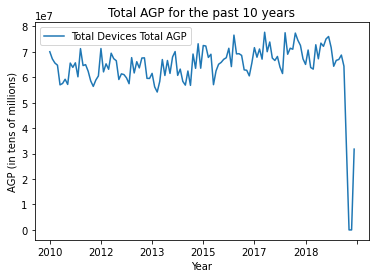

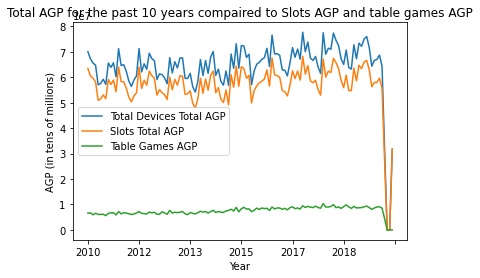

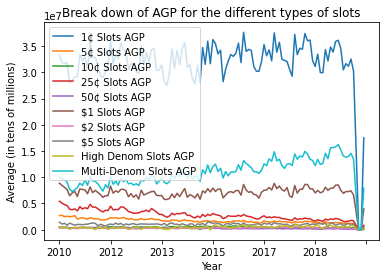

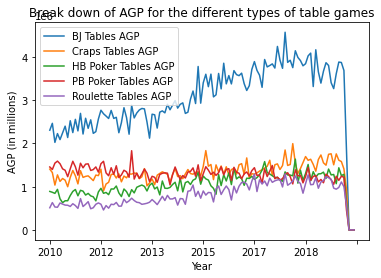

In [2]:
#plot 1
ax = plt.gca()

state_totals.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)

plt.title("Total AGP for the past 10 years")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()


#plot 2
ax = plt.gca()

state_totals.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Slots Total AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Table Games AGP',ax=ax)



plt.title("Total AGP for the past 10 years compaired to Slots AGP and table games AGP")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()


#plot 3
ax = plt.gca()

state_totals.plot(kind='line',x='year',y='1¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='5¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='10¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='25¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='50¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='$1 Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='$2 Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='$5 Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='High Denom Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Multi-Denom Slots AGP',ax=ax)
#state.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)

plt.title("Break down of AGP for the different types of slots")
plt.xlabel("Year")
plt.ylabel("Average (in tens of millions)")
plt.show()

#plot 4
ax = plt.gca()

state_totals.plot(kind='line',x='year',y='BJ Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Craps Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='HB Poker Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='PB Poker Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Roulette Tables AGP',ax=ax)
#state.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)

plt.title("Break down of AGP for the different types of table games")
plt.xlabel("Year")
plt.ylabel("AGP (in millions)")
plt.show()


state_totals.to_csv('state_totals.csv')
colors = ['r','g','b']
#plt.scatter(state.iloc[:,0],np.zeros(len(state.iloc[:,0])), color='r')
#plt.scatter(cripple.iloc[:,0],np.zeros(len(cripple.iloc[:,0])), color='g')
#plt.scatter(black.iloc[:,0],np.zeros(len(black.iloc[:,0])), color='b')

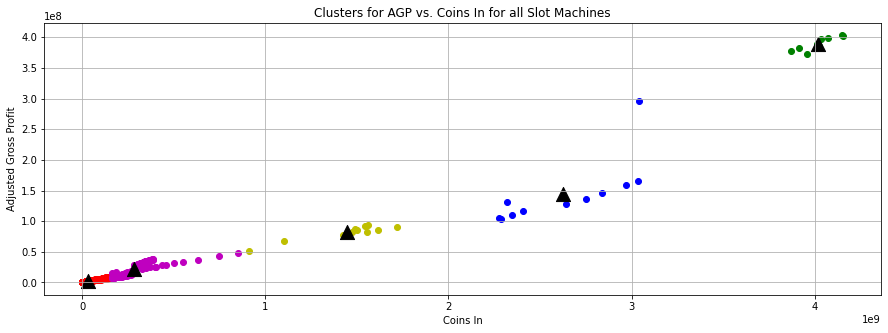

In [3]:
allsltagp = pd.concat([state.loc[:,'1¢ Slots AGP'],state.loc[:,'5¢ Slots AGP'],state.loc[:,'10¢ Slots AGP'],state.loc[:,'25¢ Slots AGP'],state.loc[:,'50¢ Slots AGP'],state.loc[:,'$1 Slots AGP'],state.loc[:,'$2 Slots AGP'],state.loc[:,'$5 Slots AGP'],state.loc[:,'High Denom Slots AGP'],state.loc[:,'Multi-Denom Slots AGP']])
allsltcoin = pd.concat([state.loc[:,'1¢ Slots Coins In'],state.loc[:,'5¢ Slots Coins In'],state.loc[:,'10¢ Slots Coins In'],state.loc[:,'25¢ Slots Coins In'],state.loc[:,'50¢ Slots Coins In'],state.loc[:,'$1 Slots Coins In'],state.loc[:,'$2 Slots Coins In'],state.loc[:,'$5 Slots Coins In'],state.loc[:,'High Denom Slots Coins In'],state.loc[:,'Multi-Denom Slots Coins In']])
plt.rcParams['figure.figsize'] = [15,5]
allsltagp = allsltagp.to_numpy()
allsltcoin = allsltcoin.to_numpy()

'''
plt.scatter(state.loc[:,'Slots Total Coins In'],state.loc[:,'Slots Total AGP'],color='r')
plt.scatter(cripple.loc[:,'Slots Total Coins In'],cripple.loc[:,'Slots Total AGP'],color='g')
plt.scatter(black.loc[:,'Slots Total Coins In'],black.loc[:,'Slots Total AGP'],color='b')
plt.scatter(central.loc[:,'Slots Total Coins In'],central.loc[:,'Slots Total AGP'],color='y')
'''

points = np.vstack((allsltcoin,allsltagp)).T
kmeansmodel = kmeans(n_clusters=5)
values = kmeansmodel.fit_predict(points)
centind0 = np.where(values[:] == 0)[0]
centind1 = np.where(values[:] == 1)[0]
centind2 = np.where(values[:] == 2)[0]
centind3 = np.where(values[:] == 3)[0]
centind4 = np.where(values[:] == 4)[0]
centroids = kmeansmodel.cluster_centers_

ax = plt.gca()
plt.grid()
#plt.scatter(allsltcoin,allsltagp,color='r')

plt.scatter(allsltcoin[centind0],allsltagp[centind0],color='r')
plt.scatter(allsltcoin[centind1],allsltagp[centind1],color='g')
plt.scatter(allsltcoin[centind2],allsltagp[centind2],color='b')
plt.scatter(allsltcoin[centind3],allsltagp[centind3],color='m')
plt.scatter(allsltcoin[centind4],allsltagp[centind4],color='y')
plt.scatter(centroids[:,0],centroids[:,1],color='k', marker='^', s = 200)
plt.xlabel('Coins In')
plt.ylabel('Adjusted Gross Profit')
plt.title('Clusters for AGP vs. Coins In for all Slot Machines')
'''
ax = plt.gca()
plt.grid()
plt.scatter(state.loc[:,'1¢ Slots Coins In'],state.loc[:,'1¢ Slots AGP'],color='b',label='1¢ Slots')
plt.scatter(state.loc[:,'5¢ Slots Coins In'],state.loc[:,'5¢ Slots AGP'],color='g',label='5¢ Slots')
plt.scatter(state.loc[:,'25¢ Slots Coins In'],state.loc[:,'25¢ Slots AGP'],color='r',label='25¢ Slots')
plt.scatter(state.loc[:,'$1 Slots Coins In'],state.loc[:,'$1 Slots AGP'],color='c',label='$1 Slots')
plt.scatter(state.loc[:,'$5 Slots Coins In'],state.loc[:,'$5 Slots AGP'],color='m',label='$5 Slots')
plt.scatter(state.loc[:,'High Denom Slots Coins In'],state.loc[:,'High Denom Slots AGP'],color='y',label='High Denom Slots')
plt.scatter(state.loc[:,'Multi-Denom Slots Coins In'],state.loc[:,'Multi-Denom Slots AGP'],color='k',label='Multi-Denom Slots')
plt.xlabel('Coins In')
plt.ylabel('AGP')
plt.title('AGP vs. Coins In for all Slot Machines')
plt.legend()
'''
plt.savefig('plt8.png')

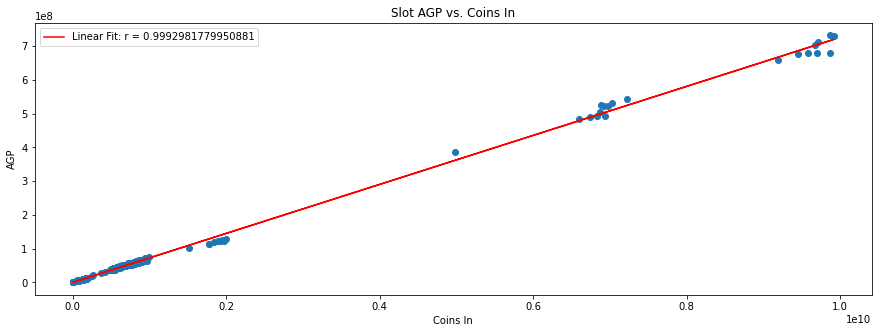

In [4]:
slotcoin = pd.concat([state.loc[:,'Slots Total Coins In'],cripple.loc[:,'Slots Total Coins In'],black.loc[:,'Slots Total Coins In'],central.loc[:,'Slots Total Coins In']],axis=0)
slotagp = pd.concat([state.loc[:,'Slots Total AGP'],cripple.loc[:,'Slots Total AGP'],black.loc[:,'Slots Total AGP'],central.loc[:,'Slots Total AGP']],axis=0)
slotagp = slotagp.to_numpy()
slotcoin = slotcoin.to_numpy()

xdata = slotcoin.reshape(-1,1)
ydata = slotagp.reshape(-1,1)
linreg = LinearRegression()
linreg.fit(xdata, ydata)
ydata_pred = linreg.predict(xdata)
corr = pears(xdata.flatten(),ydata)[0][0]
ax = plt.gca()
plt.plot(xdata,ydata_pred,'r')
plt.scatter(slotcoin,slotagp)
plt.title('Slot AGP vs. Coins In')
plt.xlabel('Coins In')
plt.ylabel('AGP')
plt.legend(['Linear Fit: r = ' + str(corr)])

In [5]:
#plot 1



state_total= state.loc[(state['month'].isin(['TOTAL']))]
state_total.loc[:,'year'] = state_total.loc[:,'year'].astype(int)
state_total=state_total.loc[(state_total['year'] < 2021)]
print(state_totals.head(20))

ax = plt.gca()
state_total.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)


plt.title("Total AGP for the past 10 years")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()
plt.savefig('Plot1.png')


#plot 2
ax = plt.gca()

state_total.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Slots Total AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Table Games AGP',ax=ax)



plt.title("Total AGP for the past 10 years compaired to Slots AGP and table games AGP")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()
plt.savefig('Plot2.png')

#plot 3
ax = plt.gca()

state_total.plot(kind='line',x='year',y='1¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='5¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='10¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='25¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='50¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='$1 Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='$2 Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='$5 Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='High Denom Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Multi-Denom Slots AGP',ax=ax)
#state.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)

plt.title("Break down of AGP for the different types of slots")
plt.xlabel("Year")
plt.ylabel("Average (in tens of millions)")
plt.show()
plt.savefig('Plot3.png')
#plot 4
ax = plt.gca()

state_total.plot(kind='line',x='year',y='BJ Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Craps Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='HB Poker Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='PB Poker Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Roulette Tables AGP',ax=ax)
#state.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)

plt.title("Break down of AGP for the different types of table games")
plt.xlabel("Year")
plt.ylabel("AGP (in millions)")
plt.show()
plt.savefig('Plot 4.png')


SyntaxError: invalid syntax (2682153021.py, line 26)

In [ ]:
gamedf_T_mod = gamedf_T.dropna(axis=0)

winfilt = (gamedf_T_mod.loc[:,'season'] == 'WINTER')
gamedf_T_mod.loc[winfilt,'season'] = 0
winfilt = (gamedf_T_mod['season'] == 'SPRING')
gamedf_T_mod.loc[winfilt,'season'] = 1
winfilt = (gamedf_T_mod['season'] == 'SUMMER')
gamedf_T_mod.loc[winfilt,'season'] = 2
winfilt = (gamedf_T_mod['season'] == 'AUTUMN')
gamedf_T_mod.loc[winfilt,'season'] = 3

slotscoinsin = gamedf_T_mod.loc[:,'Slots Total Coins In'].to_numpy().flatten(order='F')
slotsagp = gamedf_T_mod.loc[:,'Slots Total AGP'].to_numpy().flatten(order='F')
slotsseason = gamedf_T_mod.loc[:,'season'].to_numpy().flatten(order='F')

slotsseason = np.c_[ slotsseason, slotsseason, slotsseason, slotsseason ].flatten(order='F')
slotsseason = to_categorical(slotsseason, num_classes = 4)

xdata = np.c_[slotscoinsin, slotsagp]
xdata = xdata / xdata.max(axis=0)

x_train, x_test, y_train, y_test = train_test_split(xdata, slotsseason, test_size=1/10, random_state=101, shuffle=True)
y_train = np.asarray(y_train, dtype= np.int64)
y_test = np.asarray(y_test, dtype= np.int64)
x_train = np.asarray(x_train, dtype= np.float64)
x_test = np.asarray(x_test, dtype= np.float64)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape=(2,),activation="relu"))
model.add(tf.keras.layers.Dense(32,activation="relu"))
model.add(tf.keras.layers.Dense(4,activation="softmax"))

model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1/10000), \
              loss=keras.losses.CategoricalCrossentropy(), \
              metrics=[keras.metrics.CategoricalAccuracy()],)

model.fit(x = x_train, y = y_train, validation_data=(x_test, y_test), batch_size = 10, epochs = 50, shuffle = True, verbose = 2)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape=(3,),activation="relu"))
model.add(tf.keras.layers.Dense(32,activation="relu"))
model.add(tf.keras.layers.Dense(4,activation="softmax"))

model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1/10000), \
              loss=keras.losses.CategoricalCrossentropy(), \
              metrics=[keras.metrics.CategoricalAccuracy()],)

xlist = [state.loc[:,'Slots Total Coins In'].tolist() + \
                       cripple.loc[:,'Slots Total Coins In'].tolist() + \
                        black.loc[:,'Slots Total Coins In'].tolist() + \
                       central.loc[:,'Slots Total Coins In'].tolist(), \
         state.loc[:,'Slots Total AGP'].tolist() + \
         cripple.loc[:,'Slots Total AGP'].tolist() + \
         black.loc[:,'Slots Total AGP'].tolist() + \
         central.loc[:,'Slots Total AGP'].tolist(), \
        state.loc[:,'Slots Total Hold %'].tolist() + \
         cripple.loc[:,'Slots Total Hold %'].tolist() + \
         black.loc[:,'Slots Total Hold %'].tolist() + \
         central.loc[:,'Slots Total Hold %'].tolist()]
xdata = np.asarray(xlist).T

xdata = xdata / xdata.max(axis=0) # Normalized the data
rowlen = int(len(xdata) / 4)


arr1 = np.full(shape=rowlen, fill_value=0, dtype=np.int64)
arr2 = np.full(shape=rowlen, fill_value=1, dtype=np.int64)
arr3 = np.full(shape=rowlen, fill_value=2, dtype=np.int64)
arr4 = np.full(shape=rowlen, fill_value=3, dtype=np.int64)

ydata = np.concatenate((arr1,arr2,arr3,arr4), axis=None)
ydata = to_categorical(ydata, num_classes = 4)
x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=1/10, random_state=101, shuffle=True)

numepochs = 100
modmetrics = model.fit(x = x_train, y = y_train, validation_data=(x_test, y_test), batch_size = 10, epochs = numepochs, shuffle = True, verbose = 0)
epochvals = np.arange(1,numepochs + 1)

plt.figure(0)
plt.plot(epochvals, modmetrics.history['val_loss'])
plt.plot(epochvals, modmetrics.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Validation Set','Training Set'])
plt.title('Loss vs. Epoch')

plt.figure(1)
plt.plot(epochvals,modmetrics.history['val_categorical_accuracy'])
plt.plot(epochvals,modmetrics.history['categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend(['Validation Set','Training Set'])
plt.title('Categorical Accuracy vs. Epoch')
